In [21]:
import lasio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [23]:
DATA_DIR = "..\\data\\las"
EXCEL_DIR = "..\\data"

In [15]:
well_idx = []

In [16]:
for filename in os.listdir(DATA_DIR):
    # Print each filename
    well_idx.append(filename.split("_")[0])
    # print(filename)

In [18]:
well_idx = set(well_idx)

In [19]:
len(well_idx)

41

In [26]:
excel = pd.read_excel(EXCEL_DIR + "\\Отбивки пласта АС11-2.xlsx")

In [27]:
excel

,Well identifier,Surface,Z,MD
0,11,АС11-1,-2170.90,3153.43
1,11,АС11-2,-2203.47,3198.17
2,12,АС11-1,-2161.95,3038.42
3,12,АС11-2,-2183.98,3068.29
4,13,АС11-1,-2158.72,2735.19
...,...,...,...,...
91,K-45,АС11-2,-2198.70,2353.00
92,K-62,АС11-1,-2115.18,2312.90
93,K-62,АС11-2,-2138.48,2336.20
94,K-66,АС11-1,-2138.28,2757.92


In [3]:
las = lasio.read(os.path.join(DATA_DIR, "12_continuous.las"))

In [4]:
print("Well name:", las.well.WELL.value)
print("Company:", las.well.COMP.value)

# Access data
print("Depth values:", las["DEPT"])
print("Neutron porosity values:", las["NEU"])

Well name: 12
Company: 
Depth values: [0.0000000e+00 1.5240000e-01 3.0480000e-01 ... 3.1706820e+03 3.1708344e+03
 3.1709868e+03]
Neutron porosity values: [nan nan nan ... nan nan nan]


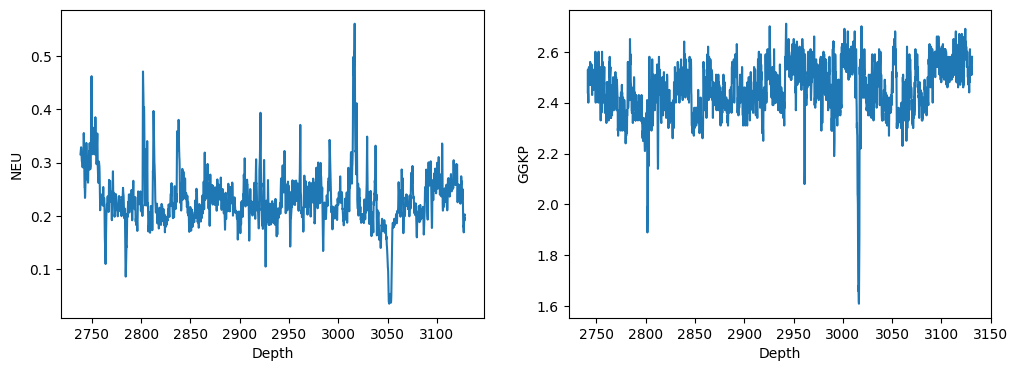

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(las["DEPT"], las["NEU"])
plt.xlabel("Depth")
plt.ylabel("NEU")
plt.subplot(122)
plt.plot(las["DEPT"], las["GGKP"])
plt.xlabel("Depth")
plt.ylabel("GGKP")
plt.show()

In [17]:
las['NEU'][~np.isnan(las['NEU'])]

array([0.3154, 0.3194, 0.3239, ..., 0.1922, 0.2027, 0.2012])

мысль - свёртки

depth - длина по стволу - по кривой
sstvd - абсолютная переведённая
z - от моря
одна положительная другая отрицательная разницы нет
лучше либо 2 либо 3

ggkp - гамма каротаж - фоновое гамма излучение

отбивки - границы пласта(субгоризонтальная бурная порода) - точка входа и выхода из целевого пласта - остальное неинтересно
Z - тот же столбик
MD - глубина

дискретные файлы
facies - ручная разметка вручную
log9 - обонзачает то же самое, просто укрупленная, достаточно одной
когда пересекаем глубину начинается код N


neu - нейтронный каротаж - неважно? можно по одной, но с этой +



суть задачи

- кластеризация всех скважин в пределах пластов по форме гамма и второго каротажа
- дальше сложнее: кластеризация кусков формы внутри пласта. То есть каждый график разбить на кусочки - берутся из дискретности. Не
- - Не всегда размечены именно формы, какой-то информации у нас может не быть
- - Цель - не 100% совпадение с разметкой ручной
- - Скользящее окно не дало плодов, проблемы - шум, интересуют крупные, на каждую скважину не более 3

отобразить, посмотреть, обрезать по пласту, поискать основные формы, описаны в какой-тио методике - простейшие геометрические - коробки, пирамиды, воронки
по второй - сложно непонятно